<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Model_training_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRY:
 - Dropout to 0.2/0.5 instead (*)
 - Bidirectional LSTM (*)
 - Learning rate scheduling (and/or stop-resume) (*)
 - TimeDistributed (Conv1D) or ConvLSTM
 - exponential smoothing (*) 

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/final_data.csv", index_col = 0, parse_dates = True)

In [0]:
df = df[df.index > "2016-06-02"]
df['density'] = (df.flow * 60) / df.speed

In [0]:
cols = ["speed", "flow", "density", "speed_limit", "holiday", "weekend"]
continuous_cols = ["speed", "flow", "density"]
discrete_cols = ["speed_limit", "holiday", "weekend"]
df = df[cols]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "15T"):
    r_df = df.copy()
    r_df = r_df.resample(freq).agg({
           "speed": np.mean, "flow": np.sum, "density": np.mean, "speed_limit": np.median, "holiday": np.median, "weekend": np.median})
    return r_df

In [0]:
r_df = resample_df(df, freq = "15T")

### Exponential smoothing

In [0]:
# import matplotlib.pyplot as plt
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.rc('legend', fontsize='x-small')
# fig, ax = plt.subplots(figsize = (6, 3), dpi = 300)
# r_df['speed'][0:96].plot(ax = ax, style = 'k-', label = 'True speed', lw = 0.4)
# r_df['speed'].rolling(3).mean()[0:96].plot(ax = ax, style = 'k:', label = 'Rolling mean', lw = 0.4)
# r_df['speed'].ewm(span = 3).mean()[0:96].plot(ax = ax, style = 'k--', label = 'Exponential smoothing', lw = 0.4)
# plt.title("Smoothing effects", fontsize = 'x-small')
# ax.set_xlabel('Time (15m)', fontsize = 'x-small')
# ax.set_ylabel('Speed (kph)', fontsize = 'x-small')
# _, labels = ax.get_legend_handles_labels()
# plt.legend(labels)
# plt.tight_layout()
# plt.savefig("plots/smoothing_effects.pdf", format = "pdf")

### Train, val, test split

In [0]:
def train_split(split_df):
    train = split_df[split_df.index.year < 2019].copy()
    val = split_df[len(train): -len(split_df[split_df.index > "2019-06"]) - 1].copy()
    test = r_df[len(train) + len(val):].copy()
    return train, val, test

train, val, test = train_split(r_df)

In [0]:
trainval = pd.concat([train, val])

### MinMax Scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(train)
# X_train = scaler.transform(train)
# y_train = X_train[:, 0]
# X_val = scaler.transform(val)
# y_val = X_val[:, 0]
# X_test = scaler.transform(test)
# y_test = X_test[:, 0]

In [0]:
scaler2 = MinMaxScaler()
scaler2.fit(trainval)
X_trainval = scaler2.transform(trainval)
y_trainval = X_trainval[:, 0]
X_test = scaler2.transform(test)
y_test = X_test[:, 0]

In [0]:
# # Shifty! 30 min prediction

# from scipy.ndimage.interpolation import shift

# y_train = shift(y_train, -1, mode = "nearest")
# y_val = shift(y_val, -1, mode = "nearest")
# y_test = shift(y_test, -1, mode = "nearest")

In [14]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

lookback = int(24 * (60 / 15))
batch_size = 512

# train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback, batch_size = batch_size)
# val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback, batch_size = batch_size)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback, batch_size = batch_size)
 
# #explore_generator = TimeseriesGenerator(X_train, y_train.shift(-forecast+1).values)

TensorFlow 2.x selected.


In [0]:
trainval_gen = TimeseriesGenerator(data = X_trainval, targets = y_trainval, length = lookback, batch_size = batch_size)

In [0]:
# ML
import tensorflow as tf
import pdb
import matplotlib.pyplot as plt
import datetime, os

In [0]:
############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24 * 4):
        super(neural_net, self).__init__()

        # Define lookback
        self.lookback = lookback

        # Define discrete feature layers
        self.discrete_flatten = tf.keras.layers.Flatten()
        self.discrete_prelu1 = tf.keras.layers.PReLU()
        self.discrete_bnorm1 = tf.keras.layers.BatchNormalization()
        self.discrete_dense1 = tf.keras.layers.Dense(32)
        self.discrete_prelu2 = tf.keras.layers.PReLU()

        # Define time feature layers
        # Time 1
        self.time1_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time1_prelu1 = tf.keras.layers.PReLU()
        self.time1_lstm1 = tf.keras.layers.LSTM(units = 32, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 64))
        self.time1_prelu2 = tf.keras.layers.PReLU()

        # Time 2
        self.time2_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time2_prelu1 = tf.keras.layers.PReLU()
        self.time2_lstm1 = tf.keras.layers.LSTM(units = 32, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 64))
        self.time2_prelu2 = tf.keras.layers.PReLU()

        # Define Merged layers
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(16)
        self.prelu1 = tf.keras.layers.PReLU()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(1, activation = 'linear')

    # Define the forward propagation
    def call(self, inputs):
        
        # Split time and discrete inputs
        x_time = inputs[:, :, :-3]
        x_discrete = inputs[:, :, -3:]

        # Run discrete layers
        x_discrete = self.discrete_flatten(x_discrete)
        x_discrete = self.discrete_prelu1(x_discrete)
        x_discrete = self.discrete_bnorm1(x_discrete)
        x_discrete = self.discrete_dense1(x_discrete)
        x_discrete = self.discrete_prelu2(x_discrete)

        # Run time layers
        x_time1 = self.time1_conv1(x_time)
        x_time1 = self.time1_prelu1(x_time1)
        x_time1 = self.time1_lstm1(x_time1)
        x_time1 = self.time1_prelu2(x_time1)
        
        x_time2 = self.time2_conv1(x_time)
        x_time2 = self.time2_prelu1(x_time2)
        x_time2 = self.time2_lstm1(x_time2)
        x_time2 = self.time2_prelu2(x_time2)

        # Concat layers
        x = tf.concat([x_time1, x_time2, x_discrete], axis = 1)
        x = self.bnorm1(x)
        x = self.dense1(x)
        x = self.prelu1(x)
        x = self.bnorm2(x)
        x = self.dense2(x)
        
        # Return output
        return x

# Create an instance of you neural network model
model = neural_net(lookback = lookback)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

# Define loss function
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Compile model
model.compile(optimizer = optimizer, loss = mse_loss_fn)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights = True)
learning_rate_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 0, mode='auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)

In [18]:
# Train model
history = model.fit(trainval_gen, validation_data = test_gen, epochs = 50, callbacks = [early_stopping, learning_rate_reduce]) #, tensorboard_callback])
train_loss, val_loss = history.history['loss'], history.history['val_loss']

  ...
    to  
  ['...']
Train for 205 steps, validate for 40 steps
Epoch 1/50
205/205 [==============================] - 60s 293ms/step - loss: 0.0482 - val_loss: 0.0050
Epoch 2/50
205/205 [==============================] - 55s 266ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 3/50
205/205 [==============================] - 54s 264ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/50
205/205 [==============================] - 55s 268ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/50
205/205 [==============================] - 54s 264ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/50
205/205 [==============================] - 56s 274ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/50
205/205 [==============================] - 56s 272ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/50
205/205 [==============================] - 55s 270ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/50
205/205 [==============================] - 55s 268ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch

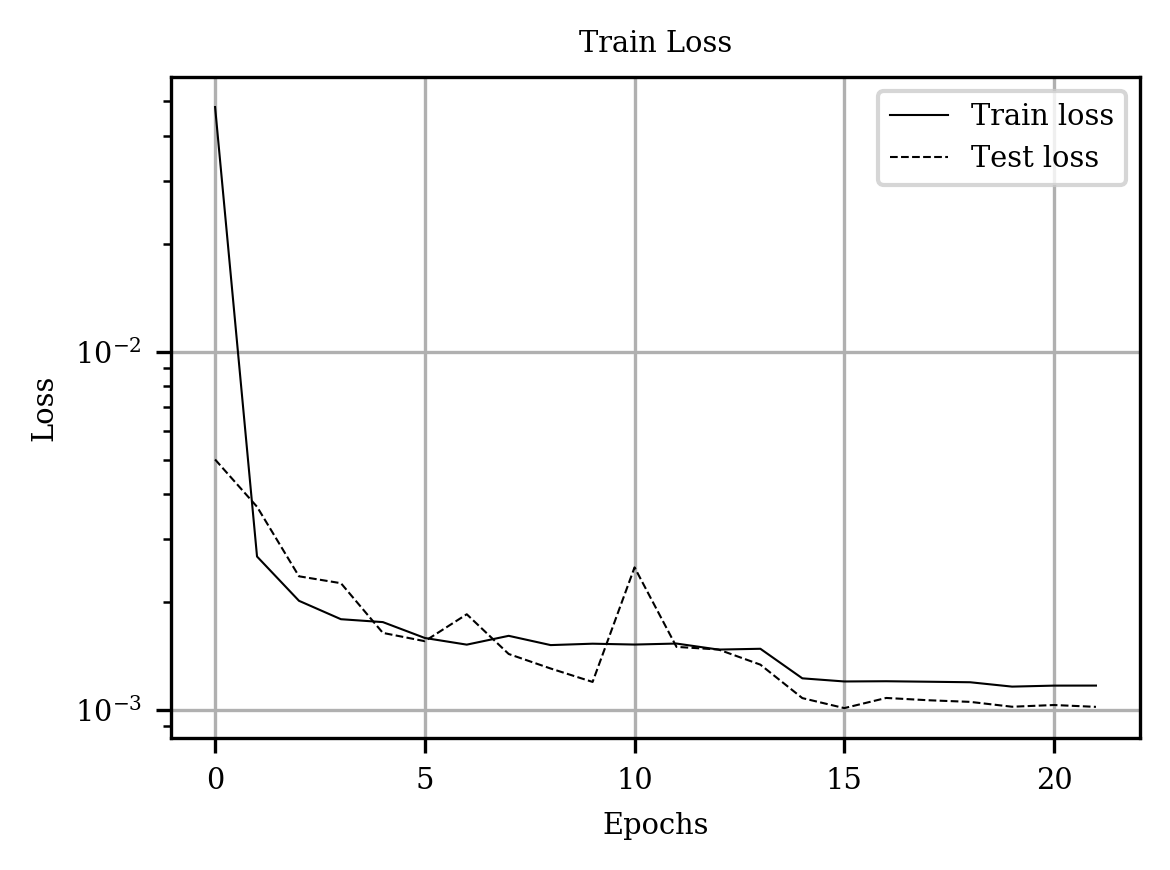

In [27]:
# Plot test and validation loss
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (4, 3)
plt.figure()
plt.semilogy(train_loss, 'k-', lw = 0.5)
plt.semilogy(val_loss, 'k--', lw = 0.5)
plt.xlabel("Epochs", fontsize = 'x-small')
plt.ylabel("Loss", fontsize = 'x-small')
plt.legend(['Train loss', 'Test loss'])
plt.grid(True)
plt.title('Train Loss', fontsize = 'x-small')
plt.tight_layout()
plt.savefig("plots/test_loss_3.pdf", format = "pdf")

In [0]:
# val_pred = model.predict(val_gen)
test_pred = model.predict(test_gen)

In [0]:
# predictions = pd.DataFrame(data = r_df.iloc[len(train) + lookback : -len(r_df[r_df.index > "2019-06"]) - 1, 0].values, index = val[lookback:].index, columns = ['True speed'])
predictions = pd.DataFrame(data = r_df.iloc[len(trainval) + lookback:, 0].values, index = test[lookback:].index, columns = ['True speed'])
# fudge = val.copy()
# fudge.iloc[lookback:, 0] = val_pred
fudge = test.copy()
fudge.iloc[lookback:, 0] = test_pred
# predictions["Predicted speed"] = scaler.inverse_transform(fudge)[lookback:, 0]
predictions["Predicted speed"] = scaler2.inverse_transform(fudge)[lookback:, 0]
predictions["Speed limit"] =  np.where(test.iloc[lookback:, test.columns.get_loc('speed_limit')] > 0.5, 130, 100)

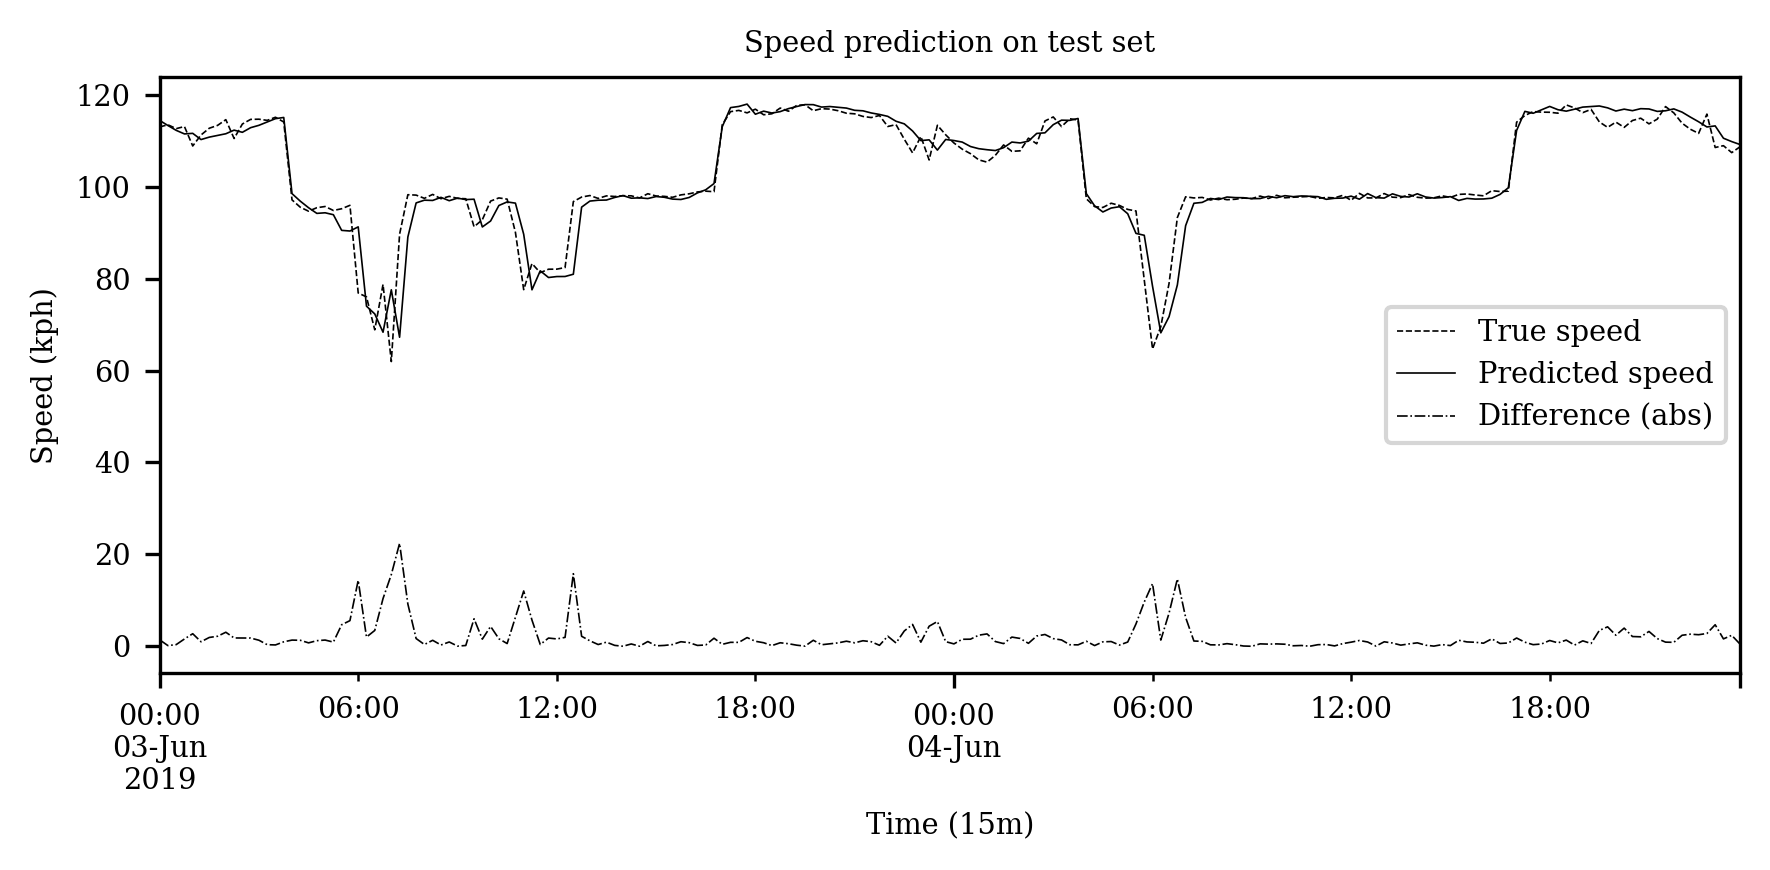

In [28]:
start = 96 * 1
end = 96 * 3
y1 = predictions["Speed limit"]
y2 = predictions["True speed"]
y3 = predictions["Predicted speed"]
y4 = abs(y2-y3)
y5 = predictions["True speed"].shift(1)
fig, ax = plt.subplots(figsize = (6, 3), sharey = True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
# y1[start:end].plot(ax = ax, style = 'k:', lw = 0.4, label = "Speed limit")
y2[start:end].plot(ax = ax, style = 'k--', lw = 0.4, label = "True speed")
# y5[start:end].plot(ax = ax, style = 'r-.', lw = 0.4, label = "Naive")
y3[start:end].plot(ax = ax, style = 'k-', lw = 0.4, label = "Predicted speed")
y4[start:end].plot(ax = ax, style = 'k-.', lw = 0.4, label = "Difference (abs)")

_, labels = ax.get_legend_handles_labels()
plt.legend(labels)
plt.title("Speed prediction on test set", fontsize = 'x-small')
ax.set_xlabel('Time (15m)', fontsize = 'x-small')
ax.set_ylabel('Speed (kph)', fontsize = 'x-small')
plt.tight_layout()
plt.savefig("plots/prediction_test_example_3.pdf", format = "pdf")

In [23]:
speed = predictions['True speed'].values
print(f"Naive R^2: {np.mean((speed[1:] - speed[:-1])**2)}")
print(f"Model R^2: {np.mean((predictions['True speed'] - predictions['Predicted speed'])**2)}")

Naive R^2: 22.223424349825223
Model R^2: 14.632717019923927


In [24]:
# Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))

  ...
    to  
  ['...']
40/40 [==============================] - 2s 51ms/step - loss: 0.0010
Test Loss: 0.0010114954729942838


In [0]:
# % val Naive R^2: 24.448094035079595
# (22.040289306899428 + 20.027088882785808 + 20.967994805328672) / 3

In [26]:
# % test Naive R^2: 22.223424349825223
# (14.808640282817311 + 14.89869155242659 + 14.632717019923927) / 3

14.780016285055941

In [0]:
# % val
# % Naive R^2: 24.448094035079595
# % #1
# % % Model R^2: 22.040289306899428
# % % loss: 0.0015 - val_loss: 0.0018
# % #2
# % Model R^2: 20.027088882785808
# % loss: 0.0013 - val_loss: 0.0016
# % #3
# % Model R^2: 20.967994805328672
# % loss: 0.0014 - val_loss: 0.0016


# % test
# % Naive R^2: 22.223424349825223

# % #1
# % Model R^2: 14.808640282817311
# % Test Loss: 0.0010
# % #2
# % Model R^2: 14.89869155242659
# % Test Loss: 0.0010
# % #3
# % Model R^2: 14.632717019923927
# % Test Loss: 0.0010